In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


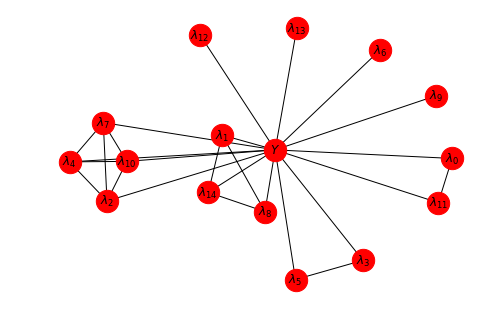

In [2]:
M = 15
N_CLUSTERS = 10
deps_graph = ClusterDependencies(M, N_CLUSTERS)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

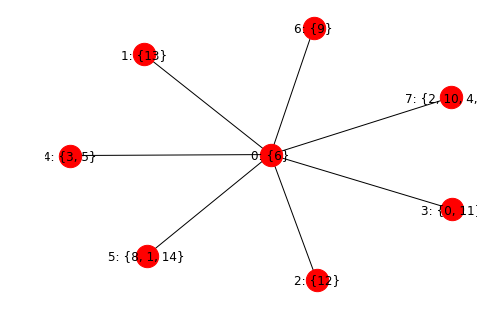

In [3]:
N = 1000 # Not used yet...
K = 2
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

In [4]:
%time sigma_O = data.get_sigma_O()

CPU times: user 3.49 s, sys: 4.06 ms, total: 3.5 s
Wall time: 3.5 s


In [5]:
np.linalg.cond(sigma_O)

1620.112248208909

In [6]:
class_balance = data.get_class_balance()
class_balance

array([0.55011845, 0.44988155])

In [7]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 1397.25769043
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


In [9]:
# If we had L_aug, could get this as the diagonal of L_aug.T @ L_aug
lps = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
mu_est = lm.get_mu(lps, c=1)

mu = data.get_mu()
np.hstack([mu_est, mu])

array([[0.32498199, 0.32498199],
       [0.25645899, 0.25645899],
       [0.30734138, 0.30734139],
       [0.19620846, 0.19620846],
       [0.36746595, 0.36746595],
       [0.2658658 , 0.26586579],
       [0.21299297, 0.21299297],
       [0.24933504, 0.24933504],
       [0.38630807, 0.38630806],
       [0.31097929, 0.31097928],
       [0.34602382, 0.34602383],
       [0.23304105, 0.23304105],
       [0.2385753 , 0.2385753 ],
       [0.30828458, 0.30828458],
       [0.34804049, 0.34804048],
       [0.16834241, 0.1683424 ],
       [0.11595301, 0.11595301],
       [0.22021836, 0.22021835],
       [0.29885832, 0.29885831],
       [0.19840358, 0.19840358],
       [0.17036685, 0.17036685],
       [0.23638987, 0.23638987],
       [0.25103828, 0.25103828],
       [0.17033589, 0.17033589],
       [0.28263433, 0.28263433],
       [0.19177461, 0.19177462],
       [0.20365835, 0.20365835],
       [0.19308466, 0.19308466],
       [0.13101288, 0.13101288],
       [0.13913138, 0.13913138],
       [0.

In [10]:
np.mean(np.abs(mu - mu_est))

3.060237715579034e-09